In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-deep')
from sklearn.metrics import confusion_matrix
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Check out the Data**

In [2]:
df = pd.read_csv('HamSpamdata.csv')
df.head()

Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# **Exploratory Data Analysis**

Let's use groupby to use describe by Category, this way we can begin to think about the features that separate ham and spam!

In [4]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

Let's make a new column to detect how long the text messages are

In [5]:
df['Length'] = df['Message'].apply(len)
df.head()

Category                                            Message  Length
0      ham  Go until jurong point, crazy.. Available only ...     111
1      ham                      Ok lar... Joking wif u oni...      29
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
3      ham  U dun say so early hor... U c already then say...      49
4      ham  Nah I don't think he goes to usf, he lives aro...      61

Let's see the percentage of ham and spam in our dataset

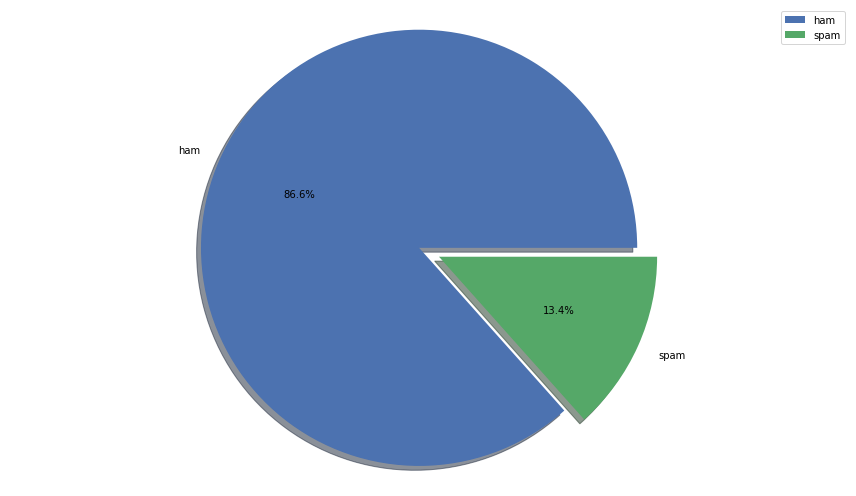

In [41]:
explode = (0.1,0)  
fig1, ax1 = plt.subplots(figsize=(12,7))
ax1.pie(df['Category'].value_counts(), explode=explode,labels=['ham','spam'], autopct='%1.1f%%',
        shadow=True)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.legend()
plt.show()

<AxesSubplot:ylabel='Frequency'>

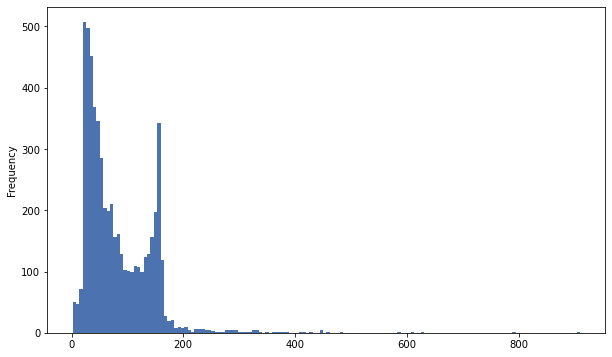

In [7]:
plt.figure(figsize=(10,6))
df['Length'].plot.hist(bins = 150)

In [8]:
df['Length'].describe()

count    5572.000000
mean       80.368988
std        59.926946
min         2.000000
25%        35.750000
50%        61.000000
75%       122.000000
max       910.000000
Name: Length, dtype: float64

One of the text has 910 characters, let's use masking to find this message:

In [9]:
df[df['Length'] == 910]['Message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

# **Text Cleaning**

Let’s clean the text for the messages in our dataset with NLP.

In [10]:
import string
from nltk.corpus import stopwords

Let's create the function to remove all punctuation, remove all stopwords and returns a list of the cleaned text 

In [11]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

Check to make sure its working

In [12]:
df['Message'].head(10).apply(text_process)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
5    [FreeMsg, Hey, darling, 3, weeks, word, back, ...
6    [Even, brother, like, speak, treat, like, aids...
7    [per, request, Melle, Melle, Oru, Minnaminungi...
8    [WINNER, valued, network, customer, selected, ...
9    [mobile, 11, months, U, R, entitled, Update, l...
Name: Message, dtype: object

**Vectorization**

Now we have the messages as lists and we need to convert each of those messages into a vector that SciKit Learn's algorithm models can work with.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer 

In [14]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(df['Message'])

Print total number of vocab words

In [15]:
print(len(bow_transformer.vocabulary_))

11422


Let's take one text message and get its bag-of-words counts as a vector, putting to use our new bow_transformer

In [16]:
message4 = df['Message'][3]
print(message4)

U dun say so early hor... U c already then say...


Now let's see its vector representation

In [17]:
bow4 = bow_transformer.transform([message4])
print(bow4)
print(bow4.shape)

  (0, 4066)	2
  (0, 4627)	1
  (0, 5258)	1
  (0, 6201)	1
  (0, 6219)	1
  (0, 7183)	1
  (0, 9551)	2
(1, 11422)


Let's see which ones appear twice in our dataset

In [18]:
print(bow_transformer.get_feature_names()[4066])
print(bow_transformer.get_feature_names()[9551])

U
say


Now let's transform the entire DataFrame of messages and create sparse matrix

In [19]:
messages_bow = bow_transformer.transform(df['Message'])

In [20]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11422)
Amount of Non-Zero occurences:  50500


In [2]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format((sparsity)))

SyntaxError: unmatched ')' (Temp/ipykernel_13844/675260581.py, line 1)

# **TF-IDF**

Now let's compute term weighting and do normalisation with TF-IDF

In [22]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(messages_bow)
print(tfidf4)

  (0, 11160)	0.23026685592418913
  (0, 10962)	0.19073428545061483
  (0, 8914)	0.24704652376837993
  (0, 8333)	0.17046869292195632
  (0, 7665)	0.26403384065473806
  (0, 7552)	0.31253856260694546
  (0, 6934)	0.1834692413608692
  (0, 6903)	0.15158474664662352
  (0, 6214)	0.18915557732842803
  (0, 5766)	0.24984711892976424
  (0, 5215)	0.26870593862526665
  (0, 5214)	0.29835184088197164
  (0, 4651)	0.31253856260694546
  (0, 2058)	0.24203960256420656
  (0, 1480)	0.31253856260694546
  (0, 1107)	0.2882862016308418
  (1, 11069)	0.40059731892909933
  (1, 10695)	0.20657545787061052
  (1, 8587)	0.5043175634668231
  (1, 7698)	0.3767229062690876
  (1, 3062)	0.2911862458354422
  (1, 2449)	0.5619631532224204
  (2, 11120)	0.19104387220509106
  (2, 11081)	0.15898145347176754
  (2, 10683)	0.13995540820792943
  :	:
  (5568, 6879)	0.31367469776242124
  (5568, 6688)	0.47781076401785183
  (5568, 6351)	0.5575721048646767
  (5568, 4878)	0.3853122086093004
  (5569, 10196)	0.520467167163554
  (5569, 8249)	0.4328

In [23]:
from sklearn.svm import SVC
start_time = time.time()

model = SVC()
model.fit(x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

NameError: name 'time' is not defined

# **Training a Random Forest model**

In [24]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10, criterion='entropy',random_state=0)
classifier.fit(tfidf4, df['Category'])

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

Let's try classifying our single random message and checking how we do:

In [25]:
print('predicted:', classifier.predict(tfidf4)[0])
print('expected:', df.Category[3])

predicted: ham
expected: ham


**Model Evaluation**

Let's check out the accuracy of our model in entire dataset

In [26]:
all_predictions = classifier.predict(messages_bow)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


Let's create classification report

In [27]:
from sklearn.metrics import classification_report
print (classification_report(df['Category'], all_predictions))

              precision    recall  f1-score   support

         ham       0.99      1.00      1.00      4825
        spam       1.00      0.96      0.98       747

    accuracy                           0.99      5572
   macro avg       1.00      0.98      0.99      5572
weighted avg       0.99      0.99      0.99      5572



In [28]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(df['Category'], all_predictions))

Accuracy: 0.9940775305096913


In the above evaluation, we evaluated accuracy on the same data we used for training. You should never actually evaluate on the same dataset you train on! the proper way is to split the data into a training set and test set,

**Train Test Split**

In [29]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(df['Message'], df['Category'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


**Creating a Data Pipeline**

Let's run our model again and then predict the test set. We will create and use a pipeline for this purpose

In [6]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVMClassifier()),  # train on TF-IDF vectors w/ SVM
])

NameError: name 'CountVectorizer' is not defined

In [ ]:
pipeline.fit(msg_train,label_train)

In [ ]:
predictions = pipeline.predict(msg_test)

# **Making Confusion Matrix**

Confusion Matrix is going to contain the correct predictions that our model made on the set as well as the incorrect predictions.

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(label_test,predictions)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

**Create classification report

In [ ]:
print(classification_report(predictions,label_test))

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(predictions,label_test))

In [ ]:
predictions = model.predict(x_test[0])
print(predictions)